<a href="https://colab.research.google.com/github/blakelobato/DS-Unit-2-Kaggle-Challenge/blob/master/module4/224A_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test


In [0]:
target = 'status_group'
# Arrange data into X features matrix and y target vector
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [6]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import category_encoders as ce
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier()
)
param = {
    'simpleimputer__strategy': ['median'],
    'randomforestclassifier__n_estimators': [150, 200, 220, 230],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__max_depth': [10,20,25, 30],
    'randomforestclassifier__min_samples_leaf': [1,3],
    'randomforestclassifier__min_samples_split': [4,5,6,7,8]
}
# If you're on Colab, decrease n_iter & cv parameters # estar n_iter=100 e n_iter=10
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param, 
    random_state=44,
    n_iter=5, 
    cv=4, 
    scoring= 'accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, y_train)
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.1min finished


Best hyperparameters {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__bootstrap': True}
Cross-validation Accuracy -0.80353891923094


In [36]:
%%time

### try ordinal encoding
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


# Arrange data to include all categorical features and not ignore those > 50
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# pipeline, but with ordinal encoder
pipeline = make_pipeline(
    #ce.OneHotEncoder(use_cat_names=True, cols=['basin']), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
   RandomForestClassifier(n_estimators=150, bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))




#81.68965 with 250, true, 35, 1, 5
#81.717 with 275, true, 40, 1, 5
#81.72447 with 275, true, 42, 1, 5 (81.0 on kaggle ouch)





Validation Accuracy 0.8142498955286251
CPU times: user 26.5 s, sys: 170 ms, total: 26.7 s
Wall time: 14.2 s


In [0]:
y_pred = pipeline.predict(X_test)
sumbission = sample_submission.copy()
sumbission['status_group'] = y_pred
sumbission.to_csv('submission_BL_8.csv', index=False)

In [29]:
!pip install matplotlib==3.1.0

In [30]:
# Compute the confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[4719,  261, 2818],
       [ 621,   38,  384],
       [3373,  190, 1954]])

In [31]:
# Get the unique labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

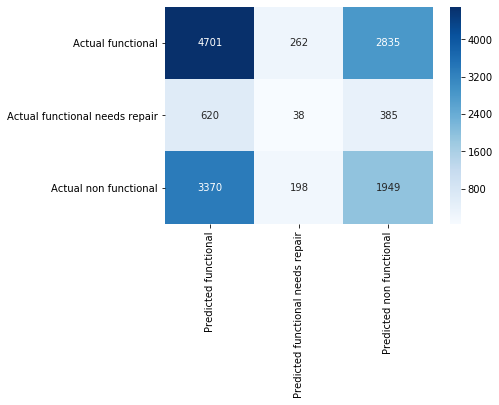

In [38]:
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                    columns = columns,
                    index = index)
  return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(y_val, y_pred);

In [33]:
!pip install scikit-plot

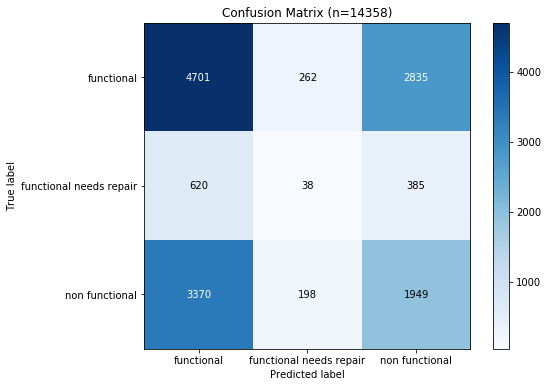

In [39]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred, 
                                    figsize=(8,6),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=False);

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.54      0.61      0.57      7798
functional needs repair       0.08      0.04      0.05      1043
         non functional       0.38      0.35      0.37      5517

               accuracy                           0.47     14358
              macro avg       0.33      0.33      0.33     14358
           weighted avg       0.45      0.47      0.45     14358

